## Task 1: Graph Cut Segmentation

**Instructions:**

- Given 2 images (asm-1, asm2), generate a bounding box for a person in each images by utilizing any deep learning-based object detectors (pretrain model).
- Leveraging the generated bounding boxes, implement graph-based image segmentation using OpenCV function, `cv2.grabCut`.
- Run GrabCut for 1, 3, and 5 iterations — report qualitative and quantitative differences.
- Visualize Results: Display original images, user masks, and final segmentation results (foreground only, and overlay).

**Deliverable:**

- Jupyter notebook with clear code and comments.

Questions:
* Will you provide asm-1 and 2 images?
* If not, what if I have a few people on each image? Should I only generete bb for one person?

In [1]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

In [6]:
def detect_person_for_grabcut(IMAGE_PATH, model):
    
    img_cv2 = cv2.imread(IMAGE_PATH)
    if img_cv2 is None:
        print(f"Could not read image: {IMAGE_PATH}")
        return None, None
        
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    results = model(img_rgb)

    result = results[0]
    person_bbox_xyxy = None
    person_bbox_xywh = None # For grabCut

    # Loop through detected objects
    for box in result.boxes:
        class_id = int(box.cls[0])

        if class_id == 0: #person class
            
            person_bbox_xyxy = list(map(int, box.xyxy[0]))
            
            # grabCut format
            x1, y1, x2, y2 = person_bbox_xyxy
            w = x2 - x1
            h = y2 - y1
            person_bbox_xywh = (x1, y1, w, h)
            
            print(f"Processing: {IMAGE_PATH}")
            print(f"Found person with confidence score: {box.conf[0]:.2f}")
            print(f"-> YOLO coordinates (x1, y1, x2, y2): {person_bbox_xyxy}")
            print(f"-> Rectangle for GrabCut (x, y, w, h): {person_bbox_xywh}")
            
            break 

    if person_bbox_xyxy:
        x1, y1, x2, y2 = person_bbox_xyxy
      
        img_with_box = cv2.rectangle(img_rgb.copy(), (x1, y1), (x2, y2), (255, 0, 0), 3) 
        
        plt.figure(figsize=(8, 8))
        plt.imshow(img_with_box)
        plt.title(f'Detected person ({IMAGE_PATH})')
        plt.axis('off')
        plt.show()
        
    else:
        print(f"No person detected on given image ({IMAGE_PATH})")
        
    return img_cv2, person_bbox_xywh


0: 448x640 1 person, 1 bicycle, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Processing: asm-1.jpg
Found person with confidence score: 0.90
-> YOLO coordinates (x1, y1, x2, y2): [261, 64, 352, 301]
-> Rectangle for GrabCut (x, y, w, h): (261, 64, 91, 237)


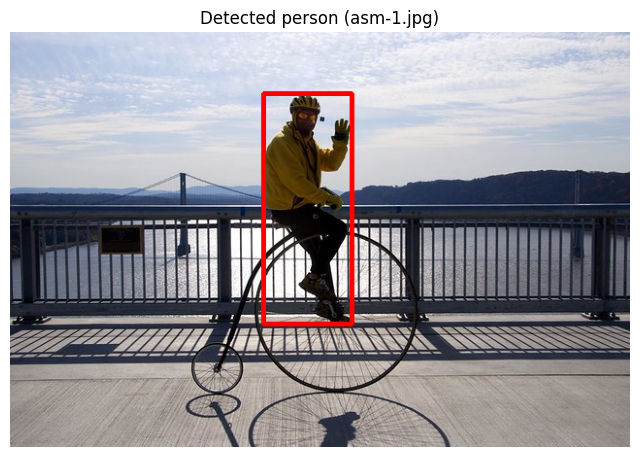


0: 448x640 1 person, 1 skateboard, 5.2ms
Speed: 0.9ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Processing: asm-2.jpg
Found person with confidence score: 0.90
-> YOLO coordinates (x1, y1, x2, y2): [192, 35, 450, 270]
-> Rectangle for GrabCut (x, y, w, h): (192, 35, 258, 235)


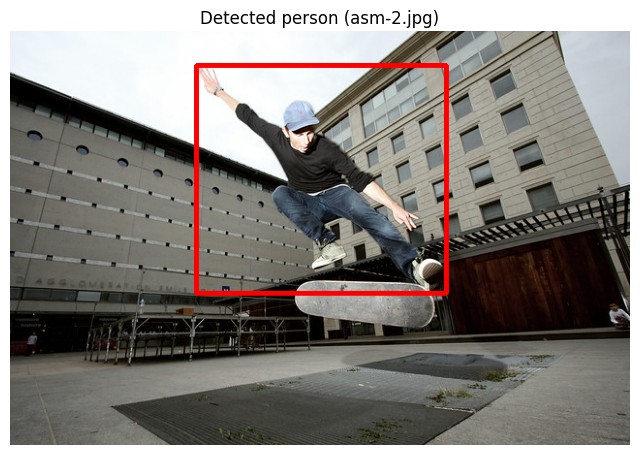

In [7]:
model = YOLO('yolov8n.pt')

IMAGE_PATH_1 = 'asm-1.jpg' 
asm_1, bbox_1 = detect_person_for_grabcut(IMAGE_PATH_1, model)

IMAGE_PATH_2 = 'asm-2.jpg' 
asm_2, bbox_2 = detect_person_for_grabcut(IMAGE_PATH_2, model)

In [8]:
def run_and_plot_grabcut(image, bbox, iterations, image_name_str):
    """
    Runs GrabCut on an image given a bounding box and plots all required results.
    Returns the final binary mask for quantitative comparison.
    """
    
    if image is None or bbox is None:
        print(f"ERROR: Skipping {image_name_str} (Image or Bbox not provided).")
        return None
        
    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = bbox

    #Based on given bbox from detection model, grabCut knows that pixels outside bbox are definitely foreground.
    #Within the background he checks if pixels are more similar to background, and creates an object segmentation mask.
    #The process is repeated iteratively, so that the mask can be improved.
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_RECT)

    # Create a new binary mask where 1 = foreground
    mask_result = np.where((mask == cv2.GC_PR_FGD) | (mask == cv2.GC_FGD), 1, 0).astype('uint8')

    img_original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get foreground only by multiplying image with the mask
    img_foreground = image * mask_result[:, :, np.newaxis]
    img_foreground_rgb = cv2.cvtColor(img_foreground, cv2.COLOR_BGR2RGB)
    
    # Create overlay (dim the background)
    img_overlay_rgb = img_original_rgb.copy()
    # Apply a dimming effect (e.g., 60% darker) to background pixels
    img_overlay_rgb[mask_result == 0] = (img_overlay_rgb[mask_result == 0] * 0.4).astype(np.uint8)

    plt.figure(figsize=(20, 5))
    plt.suptitle(f'Results for {image_name_str} ({iterations} Iterations)', fontsize=16)

    plt.subplot(1, 4, 1)
    plt.imshow(img_original_rgb)
    plt.title('1. Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mask_result, cmap='gray')
    plt.title('2. Final Mask')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(img_foreground_rgb)
    plt.title('3. Foreground Only')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(img_overlay_rgb)
    plt.title('4. Overlay')
    plt.axis('off')

    plt.show()
    return mask_result

--- STARTING ANALYSIS FOR IMAGE 1: asm-1.jpg ---


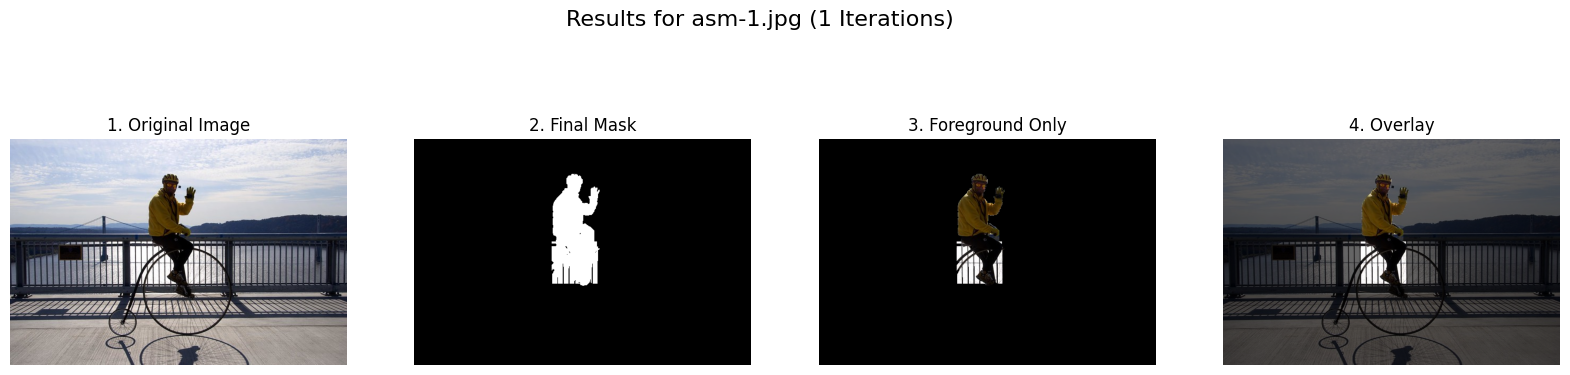

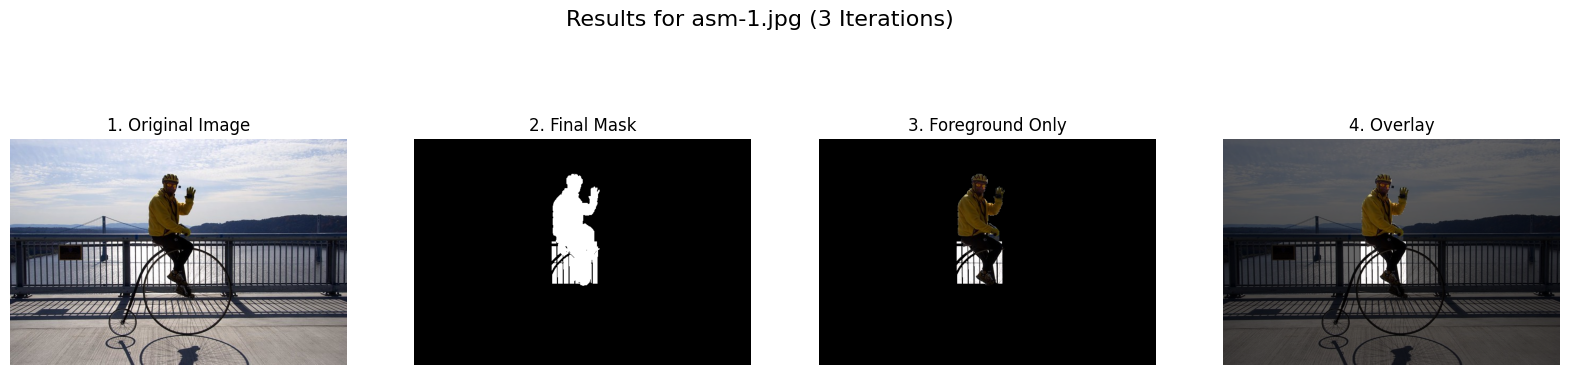

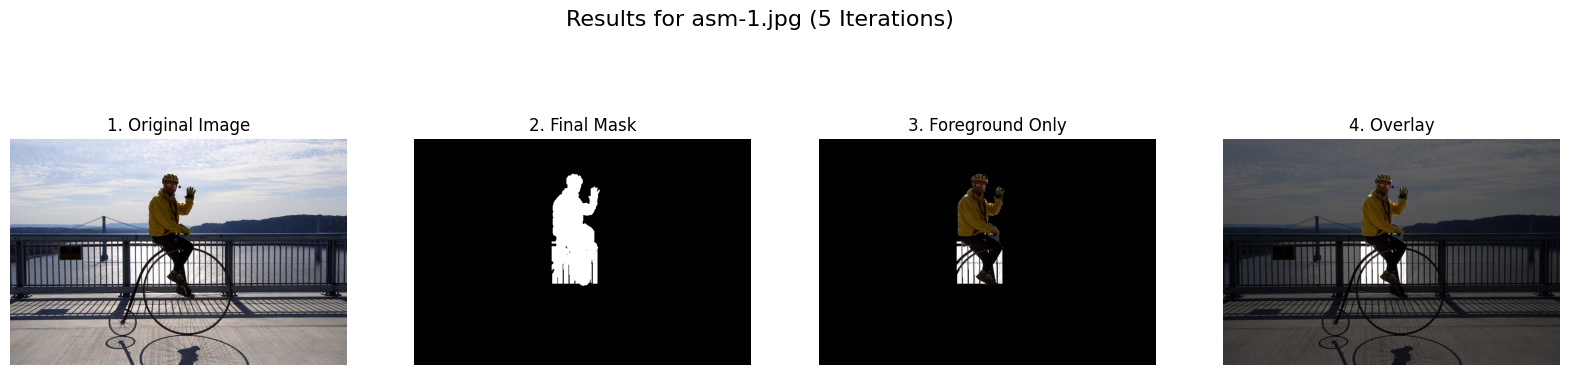


--- STARTING ANALYSIS FOR IMAGE 2: asm-2.jpg ---


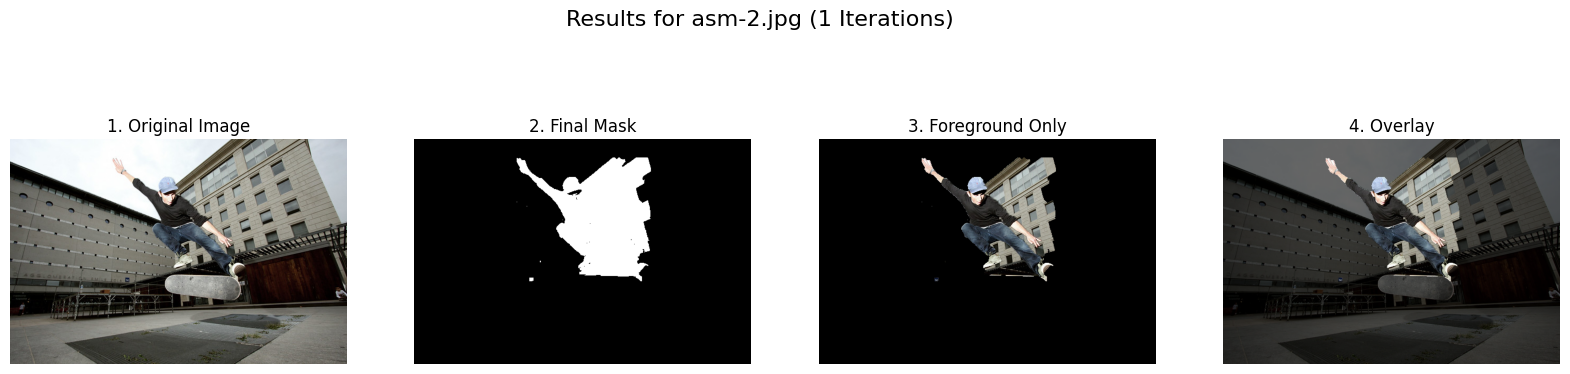

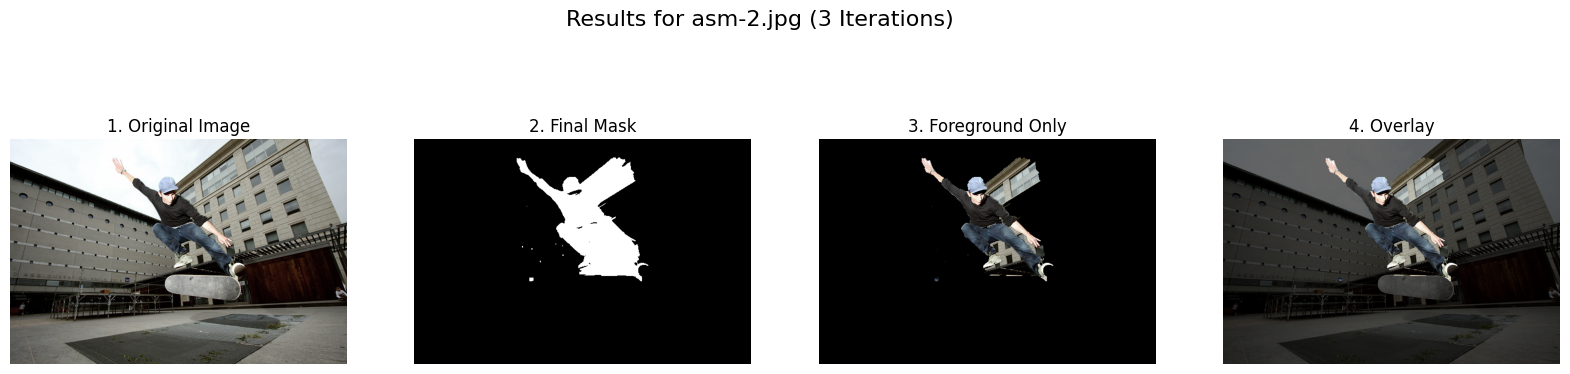

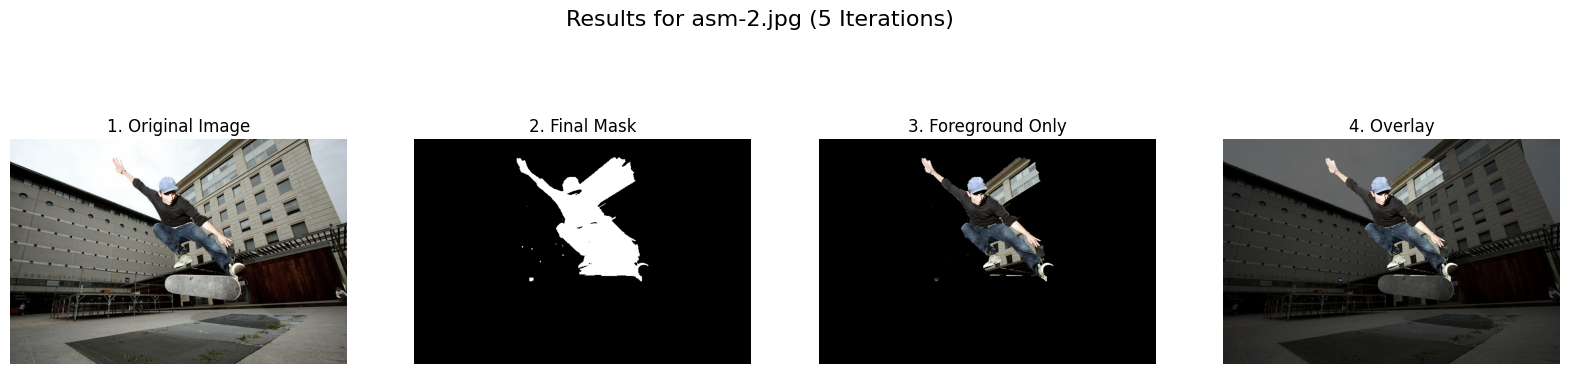

In [11]:
iterations_to_run = [1, 3, 5]

print(f"--- STARTING ANALYSIS FOR IMAGE 1: {IMAGE_PATH_1} ---")
masks_image_1 = {} 

if 'asm_1' in locals() and 'bbox_1' in locals():
    for iters in iterations_to_run:
        mask = run_and_plot_grabcut(asm_1, bbox_1, iters, IMAGE_PATH_1)
        if mask is not None:
            masks_image_1[iters] = mask
else:
    print(f"Skipping Image 1, variables 'image_1' or 'bbox_1' not found.")

print(f"\n--- STARTING ANALYSIS FOR IMAGE 2: {IMAGE_PATH_2} ---")
masks_image_2 = {} # Store masks for image 2

if 'asm_2' in locals() and 'bbox_2' in locals():
    for iters in iterations_to_run:
        mask = run_and_plot_grabcut(asm_2, bbox_2, iters, IMAGE_PATH_2)
        if mask is not None:
            masks_image_2[iters] = mask
else:
    print(f"Skipping Image 2, variables 'image_2' or 'bbox_2' not found.")

For the image1 i don't see much difference between 1, 3 and 5 i9nterations. Person mask looks the same to me. Unfortunateluy the algorithm was not able to get rid of the railing that is behind the person.

For the image2 there is a big improvement between 1 and 3 iterations. Algorithm cut out big part of the building from behind the person. Unfortunately the mask stilll includes a window even after 5 iterations, so the mask is not perfect.